# Deep learning model with multiple outputs

- Train net with two outputs
- Example uses neural net to fit multivariate regression problem with multiple outputs (MO)

Dataset is the UCI energy efficiency set [here](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency).

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

### Load data from Excel

In [4]:
dataset = pd.read_excel('data/ENB2012_data.xlsx')

In [15]:
df = dataset.\
        dropna(axis=0, how='all').\
        drop(['Unnamed: 10', 'Unnamed: 11'], axis=1).\
        sample(frac=1).\
        reset_index(drop=True)

In [16]:
df

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.76,661.5,416.5,122.5,7.0,3.0,0.10,1.0,32.12,34.07
1,0.82,612.5,318.5,147.0,7.0,4.0,0.25,1.0,26.97,27.25
2,0.82,612.5,318.5,147.0,7.0,2.0,0.25,5.0,25.70,26.53
3,0.82,612.5,318.5,147.0,7.0,5.0,0.10,4.0,24.24,25.16
4,0.76,661.5,416.5,122.5,7.0,2.0,0.10,5.0,32.31,34.25
...,...,...,...,...,...,...,...,...,...,...
763,0.76,661.5,416.5,122.5,7.0,2.0,0.25,1.0,36.96,36.85
764,0.64,784.0,343.0,220.5,3.5,4.0,0.25,2.0,17.02,20.48
765,0.90,563.5,318.5,122.5,7.0,3.0,0.00,0.0,21.46,25.38
766,0.82,612.5,318.5,147.0,7.0,2.0,0.40,2.0,28.95,30.34


### Split into train and test data

In [62]:
train, test = train_test_split(df, test_size=0.2)

# Make stats on input variables
train_stats = train.\
                describe().\
                drop(['Y1', 'Y2'], axis=1).\
                transpose()

test_stats = test.\
                describe().\
                drop(['Y1', 'Y2'], axis=1).\
                transpose()

### Make dependent variables

In [63]:
y1 = np.array(train.pop('Y1'))
y2 = np.array(train.pop('Y2'))
train_Y = (y1, y2)

In [64]:
y1 = np.array(test.pop('Y1'))
y2 = np.array(test.pop('Y2'))
test_Y = (y1, y2)

Normalize the independent variables

In [65]:
train_norm = (train - train_stats['mean'])/train_stats['std']
test_norm = (test - test_stats['mean'])/test_stats['std']

## Build non-sequential MO model

In [71]:
input_dim = len(train.columns)

In [107]:
def simo_model():
    la0 = Input(shape=(input_dim,), name='input')                   # input in R^8
    la1 = Dense(units=128, activation='relu', name='dense1')(la0)   # gets from input layer
    la2 = Dense(units=128, activation='relu', name='dense2')(la1)   # fully connected from layer 1
    la3 = Dense(units=64,  activation='relu', name='dense3')(la2)   # fully connected from layer 2
    
    y1_out = Dense(units=1, name='y1_out')(la2)
    y2_out = Dense(units=1, name='y2_out')(la3)
    
    return Model(inputs=[la0], outputs=[y1_out, y2_out])

### Get model, compile

In [108]:
model = simo_model()

opt = tf.keras.optimizers.SGD(lr=0.001)

model.compile(
    optimizer=opt,
    loss={
        'y1_out': 'mse',
        'y2_out': 'mse',
    },
    metrics={
        'y1_out': tf.keras.metrics.RootMeanSquaredError(),
        'y2_out': tf.keras.metrics.RootMeanSquaredError(),
    }
)

### Train!

In [109]:
hist = model.fit(
    train_norm,
    train_Y,
    epochs=500,
    validation_data=(test_norm, test_Y),
    verbose=False
)

In [110]:
model.evaluate(x=test_norm, y=test_Y)

5/5 [==============================] - 0s 1ms/step - loss: 4.8400 - y1_out_loss: 0.7300 - y2_out_loss: 4.1100 - y1_out_root_mean_squared_error: 0.8544 - y2_out_root_mean_squared_error: 2.0273


[4.839954376220703,
 0.7299944162368774,
 4.109959602355957,
 0.8543971180915833,
 2.027303457260132]

### Out-of-sample predictions with the model and plot comparison

In [111]:
y_hat = model.predict(test_norm)

In [112]:
def perf_scatter(y_true, y_hat, name):
    plt.scatter(y_true, y_hat)
    plt.title(name)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()

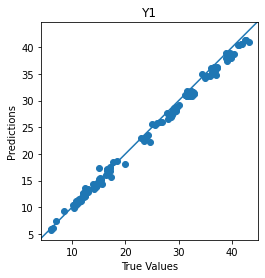

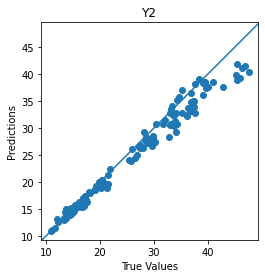

In [113]:
perf_scatter(test_Y[0], y_hat[0], 'Y1')
perf_scatter(test_Y[1], y_hat[1], 'Y2')

Performance looks okay, as 
- predictions line up with true values
- no obvious non-linearities or systematic deviations
- tendency for heteroscedastic error and systematic under-prediction near high end of Y2, could be worth exploring further

### RMSE training performance

In [118]:
print(hist.history.keys())

dict_keys(['loss', 'y1_out_loss', 'y2_out_loss', 'y1_out_root_mean_squared_error', 'y2_out_root_mean_squared_error', 'val_loss', 'val_y1_out_loss', 'val_y2_out_loss', 'val_y1_out_root_mean_squared_error', 'val_y2_out_root_mean_squared_error'])


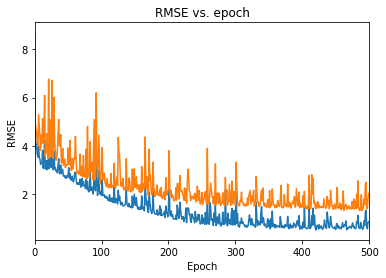

In [125]:
plt.plot(hist.history['val_y1_out_root_mean_squared_error']);
plt.plot(hist.history['val_y2_out_root_mean_squared_error']);
plt.xlim(0, 500)
plt.title('RMSE vs. epoch')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.show()